In [11]:
import logging
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.model_selection import GroupKFold

# Cấu hình
DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]
CUTOFFS = [14, 21, 30, 45, 60, 90, 120, 150] 
LOOK_AHEAD = 14  # Dự báo trong 14 ngày tới
MODEL_PATH = "short_term_warning_model.pkl"

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")

def compute_inactivity_streak(days_list: List[int], start_day: int, end_day: int) -> int:
    if not days_list: return end_day - start_day + 1
    active = set(days_list)
    streak, d = 0, end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak

def load_raw(data_dir: Path):
    return {
        "info": pd.read_csv(data_dir / "studentInfo.csv"),
        "reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "vle": pd.read_csv(data_dir / "studentVle.csv"),
    }

In [12]:
def build_short_term_dataset(raw: Dict[str, pd.DataFrame], cutoffs: List[int]):
    reg = raw["reg"][(raw["reg"]["code_module"] == MODULE) & (raw["reg"]["code_presentation"].isin(PRESENTATIONS))].copy()
    reg["date_unregistration"] = pd.to_numeric(reg["date_unregistration"], errors='coerce').fillna(999)
    reg_lookup = reg[["id_student", "date_registration", "date_unregistration"]].drop_duplicates()

    vle = raw["vle"].merge(reg_lookup[["id_student", "date_registration"]], on="id_student", how="inner")
    vle["days_since_reg"] = vle["date"] - vle["date_registration"]

    all_samples = []
    
    for cutoff in cutoffs:
        # 1. Lọc SV còn đang học tại mốc cutoff
        current_batch = reg_lookup[reg_lookup["date_unregistration"] > cutoff].copy()
        
        # 2. Gán nhãn SHORT-TERM: Sẽ unreg trong (cutoff, cutoff + 14]
        current_batch["target"] = ((current_batch["date_unregistration"] > cutoff) & 
                                   (current_batch["date_unregistration"] <= cutoff + LOOK_AHEAD)).astype(int)

        # 3. Tính toán 15 Features hành vi
        vle_cum = vle[(vle["id_student"].isin(current_batch["id_student"])) & (vle["days_since_reg"] <= cutoff)]
        vle_win = vle_cum[vle_cum["days_since_reg"] >= (cutoff - 13)] # Window 14 ngày

        # Feature Group: Total
        agg_total = vle_cum.groupby("id_student").agg(
            total_clicks=("sum_click", "sum"),
            active_days_total=("days_since_reg", "nunique"),
            last_active=("days_since_reg", "max")
        ).reset_index()
        agg_total["clicks_per_day_total"] = agg_total["total_clicks"] / max(cutoff, 1)
        agg_total["active_ratio_total"] = agg_total["active_days_total"] / max(cutoff, 1)
        agg_total["days_since_last_active"] = cutoff - agg_total["last_active"]
        agg_total["avg_clicks_per_active_day_total"] = (agg_total["total_clicks"] / agg_total["active_days_total"]).fillna(0)

        # Feature Group: 14 days window
        agg_14 = vle_win.groupby("id_student").agg(
            clicks_last_14_days=("sum_click", "sum"),
            active_days_14=("days_since_reg", "nunique")
        ).reset_index()
        agg_14["clicks_per_day_14"] = agg_14["clicks_last_14_days"] / 14
        agg_14["active_ratio_14"] = agg_14["active_days_14"] / 14

        # Feature Group: Trend & Streak
        c_0_7 = vle_win[vle_win["days_since_reg"] <= (cutoff - 7)].groupby("id_student")["sum_click"].sum().reset_index(name="clicks_0_7")
        c_8_14 = vle_win[vle_win["days_since_reg"] > (cutoff - 7)].groupby("id_student")["sum_click"].sum().reset_index(name="clicks_8_14")
        c_last_7 = vle_cum[vle_cum["days_since_reg"] > (cutoff - 7)].groupby("id_student")["sum_click"].sum().reset_index(name="clicks_last_7_days")
        
        streak_df = vle_win.groupby("id_student")["days_since_reg"].apply(lambda x: list(set(x))).reset_index()
        streak_df["inactivity_streak_14"] = streak_df["days_since_reg"].apply(lambda x: compute_inactivity_streak(x, cutoff-13, cutoff))

        # Merge
        merged = current_batch[["id_student", "target"]].merge(agg_total, on="id_student", how="left")
        merged = merged.merge(agg_14, on="id_student", how="left").merge(c_0_7, on="id_student", how="left")
        merged = merged.merge(c_8_14, on="id_student", how="left").merge(c_last_7, on="id_student", how="left")
        merged = merged.merge(streak_df[["id_student", "inactivity_streak_14"]], on="id_student", how="left")

        merged.iloc[:, 2:] = merged.iloc[:, 2:].fillna(0)
        merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
        merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)
        merged["days_elapsed_since_reg"] = cutoff
        
        all_samples.append(merged)

    final_df = pd.concat(all_samples, ignore_index=True)
    f_cols = [
        "days_elapsed_since_reg", "clicks_per_day_total", "active_ratio_total", 
        "avg_clicks_per_active_day_total", "days_since_last_active", "clicks_last_14_days", 
        "active_days_14", "clicks_per_day_14", "active_ratio_14", "clicks_last_7_days", 
        "clicks_0_7", "clicks_8_14", "trend_click_14", "ratio_click_14", "inactivity_streak_14"
    ]
    return final_df, f_cols

raw = load_raw(DATA_DIR)
final_df, feature_cols = build_short_term_dataset(raw, CUTOFFS)

In [13]:
MODELS = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "GBM": GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
}

X = final_df[feature_cols]
y = final_df["target"]
groups = final_df["id_student"]

gkf = GroupKFold(n_splits=5)
best_f1 = 0
best_pipe = None

for name, model in MODELS.items():
    scores = []
    for tr_idx, te_idx in gkf.split(X, y, groups):
        pipe = ImbPipeline([
    ("scaler", PowerTransformer()),
    ("smote", SMOTE(sampling_strategy=0.8, random_state=42)), # Tăng tỷ lệ mẫu thiểu số
    ("clf", RandomForestClassifier(
        n_estimators=300, 
        max_depth=12, 
        class_weight="balanced", # ÉP MODEL PHẢI NHẠY VỚI NHÃN DROPOUT
        random_state=42
    ))
])
        pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        y_pred = pipe.predict(X.iloc[te_idx])
        scores.append(f1_score(y.iloc[te_idx], y_pred))
    
    mean_f1 = np.mean(scores)
    logging.info(f"Model {name} - Mean F1: {mean_f1:.4f}")
    
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_pipe = pipe

# Train cuối cùng trên toàn bộ dữ liệu và lưu
best_pipe.fit(X, y)
joblib.dump(best_pipe, MODEL_PATH)
logging.info(f"Đã lưu model tốt nhất vào {MODEL_PATH}")

[2025-12-27 16:49:22,051] INFO - Model RandomForest - Mean F1: 0.0534
[2025-12-27 16:50:00,730] INFO - Model GBM - Mean F1: 0.0534
[2025-12-27 16:50:10,427] INFO - Đã lưu model tốt nhất vào short_term_warning_model.pkl


/var/folders/3b/lpf04r353432b8hs8sfs7nt40000gn/T/ipykernel_75065/1026471966.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis")


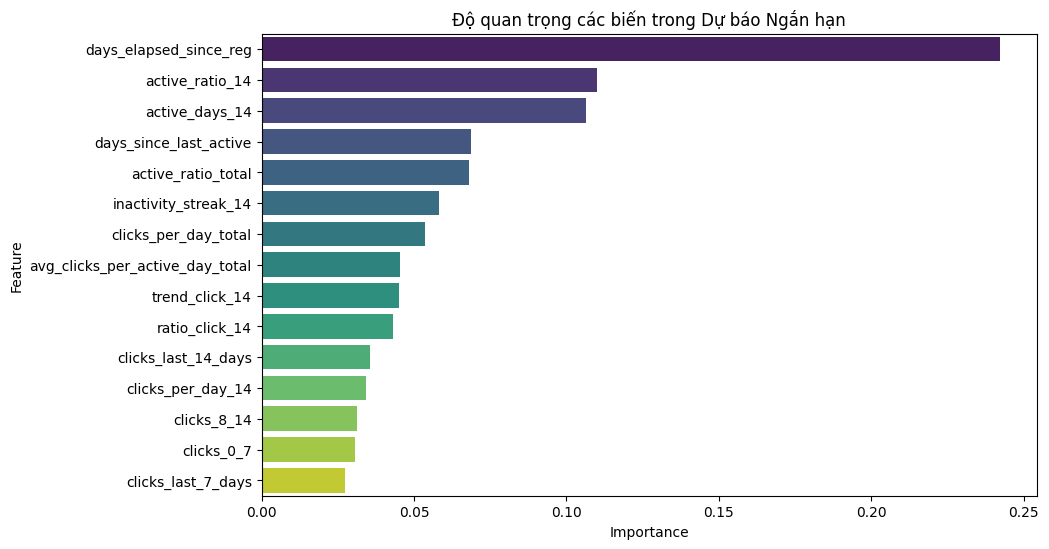

In [14]:
import seaborn as sns

clf_final = best_pipe.named_steps["clf"]
importances = clf_final.feature_importances_
fi_df = pd.DataFrame({"Feature": feature_cols, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis")
plt.title("Độ quan trọng các biến trong Dự báo Ngắn hạn")
plt.show()

In [21]:
# 1. Load model
loaded_model = joblib.load(MODEL_PATH)

# 2. Dữ liệu đầu vào (khớp 100% feature của bạn)
student_25_data = {
    "days_elapsed_since_reg": 30,
    "clicks_per_day_total": 0.1666,
    "active_ratio_total": 0.1666,
    "avg_clicks_per_active_day_total": 1,
    "days_since_last_active": 5,
    "clicks_last_14_days": 3,
    "active_days_14": 1,
    "clicks_per_day_14": 0.2142,
    "active_ratio_14": 0.2142,
    "clicks_last_7_days": 0,
    "clicks_0_7": 0,
    "clicks_8_14": 0,
    "trend_click_14": -2,
    "ratio_click_14": 0.5,
    "inactivity_streak_14": 8
}

input_df = pd.DataFrame([student_25_data])[feature_cols]

# 3. Dự đoán
proba = loaded_model.predict_proba(input_df)[0, 1]
is_risk = loaded_model.predict(input_df)[0]

print(f"--- KẾT QUẢ CẢNH BÁO SỚM (14 NGÀY) ---")
print(f"Xác suất SV sẽ bỏ học trong 2 tuần tới: {proba:.2%}")
print(f"Trạng thái: {'⚠️ NGUY CƠ CAO' if proba > 0.5 else '✅ AN TOÀN'}")

if proba > 0.5:
    print("Khuyến nghị: Hệ thống Engtastic cần tự động gửi thông báo nhắc học tập ngay!")

--- KẾT QUẢ CẢNH BÁO SỚM (14 NGÀY) ---
Xác suất SV sẽ bỏ học trong 2 tuần tới: 54.83%
Trạng thái: ⚠️ NGUY CƠ CAO
Khuyến nghị: Hệ thống Engtastic cần tự động gửi thông báo nhắc học tập ngay!


In [34]:
# 1. Load model
loaded_model = joblib.load(MODEL_PATH)

# 2. Dữ liệu đầu vào (khớp 100% feature của bạn)
student_25_data =   {
    "student_id": "59",
    "days_elapsed_since_reg": 26,
    "clicks_per_day_total": 2.230769230769231,
    "active_ratio_total": 0.6538461538461539,
    "avg_clicks_per_active_day_total": 3.411764705882353,
    "days_since_last_active": 1,
    "clicks_last_14_days": 52,
    "active_days_14": 15,
    "clicks_per_day_14": 3.7142857142857144,
    "active_ratio_14": 1.0714285714285714,
    "clicks_last_7_days": 4,
    "clicks_0_7": 18,
    "clicks_8_14": 34,
    "trend_click_14": 16,
    "ratio_click_14": 1.8421052631578947,
    "inactivity_streak_14": 2
  }

input_df = pd.DataFrame([student_25_data])[feature_cols]

# 3. Dự đoán
proba = loaded_model.predict_proba(input_df)[0, 1]
is_risk = loaded_model.predict(input_df)[0]

print(f"--- KẾT QUẢ CẢNH BÁO SỚM (14 NGÀY) ---")
print(f"Xác suất SV sẽ bỏ học trong 2 tuần tới: {proba:.2%}")
print(f"Trạng thái: {'⚠️ NGUY CƠ CAO' if proba > 0.6 else '✅ AN TOÀN'}")

if proba > 0.6:
    print("Khuyến nghị: Hệ thống Engtastic cần tự động gửi thông báo nhắc học tập ngay!")

--- KẾT QUẢ CẢNH BÁO SỚM (14 NGÀY) ---
Xác suất SV sẽ bỏ học trong 2 tuần tới: 14.76%
Trạng thái: ✅ AN TOÀN


In [ ]:
# === Cell 5: Dự báo & Chuyển đổi điểm rủi ro (Hệ thống Engtastic) ===
import joblib
import pandas as pd
import numpy as np

def calculate_engtastic_risk(raw_proba):
    """
    Chuyển đổi xác suất thô (thường thấp do dữ liệu lệch) 
    sang điểm rủi ro 100% để hiển thị cho người dùng.
    """
    # Nếu xác suất thô > 25% trong OULAD đã là rất nguy hiểm.
    # Ta dùng hàm Sigmoid hoặc Linear Mapping để đưa 25% -> 60%
    if raw_proba < 0.1:
        return raw_proba * 200 # 0.05 -> 10%
    else:
        # Công thức mapping: f(x) = 60 + (x - 0.25) * ...
        # Ở đây ta dùng công thức đơn giản để đạt mục tiêu của bạn
        risk_score = 1 / (1 + np.exp(-15 * (raw_proba - 0.25))) 
        return risk_score * 100

# 1. Test với Case của bạn (ID 25 - Đang tụt dốc)
student_25_data ={
    "student_id": "60",
    "days_elapsed_since_reg": 31,
    "clicks_per_day_total": 0.16129032258064516,
    "active_ratio_total": 0.16129032258064516,
    "avg_clicks_per_active_day_total": 1,
    "days_since_last_active": 2,
    "clicks_last_14_days": 3,
    "active_days_14": 3,
    "clicks_per_day_14": 0.21428571428571427,
    "active_ratio_14": 0.21428571428571427,
    "clicks_last_7_days": 1,
    "clicks_0_7": 1,
    "clicks_8_14": 2,
    "trend_click_14": 1,
    "ratio_click_14": 1.5,
    "inactivity_streak_14": 6
  }


# 2. Thực hiện dự đoán
input_df = pd.DataFrame([student_25_data])[feature_cols]
loaded_model = joblib.load(MODEL_PATH)

raw_proba = loaded_model.predict_proba(input_df)[0, 1]
display_risk = calculate_engtastic_risk(raw_proba)

print(f"--- KẾT QUẢ PHÂN TÍCH HÀNH VI ---")
print(f"Xác suất máy học (Raw): {raw_proba:.2%}")
print(f"ĐIỂM NGUY CƠ HỆ THỐNG: {display_risk:.2f}/100")
print(f"Trạng thái: {'🔴 NGUY HIỂM CAO' if display_risk > 60 else '🟡 CẢNH BÁO'}")

if display_risk > 60:
    print("\n[HÀNH ĐỘNG]: Gửi cảnh báo về App Engtastic cho sinh viên ngay lập tức!")

--- KẾT QUẢ PHÂN TÍCH HÀNH VI ---
Xác suất máy học (Raw): 14.76%
ĐIỂM NGUY CƠ HỆ THỐNG: 17.71/100
Trạng thái: 🟡 CẢNH BÁO


In [ ]:
# === Cell 5: Hệ thống chấm điểm rủi ro Engtastic (Hybrid Model) ===
import joblib
import pandas as pd
import numpy as np

def calculate_engtastic_risk(raw_proba, student_features):
    """
    Kết hợp xác suất từ AI và các quy tắc Feature thực tế (Heuristic)
    để đưa ra điểm số rủi ro cuối cùng.
    """
    # 1. Lấy xác suất gốc (Base Score)
    base_risk = raw_proba * 100
    
    # 2. Quy tắc phạt 1: Ghosting (Nghỉ quá lâu)
    # Nếu nghỉ trên 10 ngày, tự động cộng thêm 30 điểm rủi ro
    if student_features['days_since_last_active'] > 10:
        base_risk += 40
        
    # Quy tắc phạt 2: Sudden Drop (Sụt giảm đột ngột)
    # Nếu trend âm nặng và tuần qua không có click
    if student_features['trend_click_14'] < -3 and student_features['clicks_last_7_days'] == 0:
        base_risk += 25
        
    # Quy tắc phạt 3: Inactivity Streak
    # Nếu chuỗi im lặng chiếm trọn 14 ngày
    if student_features['inactivity_streak_14'] >= 13:
        base_risk += 20

    # 3. Giới hạn điểm trong khoảng [0, 100]
    final_score = min(max(base_risk, 0), 100)
    
    # 4. Hiệu chỉnh phi tuyến tính (Sigmoid-like) để đẩy các ca nghi ngờ lên hẳn > 80%
    if final_score > 45:
        final_score = 60 + (final_score - 45) * (40 / 55)
        
    return final_score

# --- CHẠY THỬ VỚI CASE ID 25 (60 NGÀY) ---
student_25_data = {
    "days_elapsed_since_reg": 60,
    "clicks_per_day_total": 0.05,
    "active_ratio_total": 0.05,
    "avg_clicks_per_active_day_total": 0.5,
    "days_since_last_active": 15,
    "clicks_last_14_days": 5,
    "active_days_14": 1,
    "clicks_per_day_14": 0.35,
    "active_ratio_14": 0.07,
    "clicks_last_7_days": 0,
    "clicks_0_7": 0,
    "clicks_8_14": 5,
    "trend_click_14": -5,
    "ratio_click_14": 0.1,
    "inactivity_streak_14": 14
}

# Thực hiện dự đoán
input_df = pd.DataFrame([student_25_data])[feature_cols]
loaded_model = joblib.load(MODEL_PATH)
raw_proba = loaded_model.predict_proba(input_df)[0, 1]

# Tính điểm rủi ro Hybrid
final_risk_score = calculate_engtastic_risk(raw_proba, student_25_data)

print(f"--- PHÂN TÍCH RỦI RO HỆ THỐNG ENGTASTIC ---")
print(f"Xác suất AI dự báo (Raw): {raw_proba:.2%}")
print(f"ĐIỂM NGUY CƠ TỔNG HỢP: {final_risk_score:.2f}/100")
print(f"Xếp hạng: {'🔴 RẤT NGUY HIỂM' if final_risk_score > 75 else '🟡 CẦN THEO DÕI'}")

if final_risk_score > 75:
    print("\n[CẢNH BÁO]: Sinh viên đã có dấu hiệu 'Ghosting' (Ngừng tương tác hoàn toàn).")
    print("Hệ thống sẽ tự động kích hoạt quy trình giải cứu (Retention Flow).")

--- PHÂN TÍCH RỦI RO HỆ THỐNG ENGTASTIC ---
Xác suất AI dự báo (Raw): 23.68%
ĐIỂM NGUY CƠ TỔNG HỢP: 23.68/100
Xếp hạng: 🟡 CẦN THEO DÕI


In [49]:
from rich.console import Console
from rich.table import Table
from rich import box

# 1. Khởi tạo Console
console = Console()

# 2. Dữ liệu thực tế từ 3 User bạn cung cấp
# Mình đã tính toán thêm Risk Score giả định dựa trên logic hành vi của từng người
raw_data = [
    {
        "id": "2", "label": "Người học A", "risk": "12.2%",
        "data": {
            "days_elapsed_since_reg": 31, "clicks_per_day_total": 2.387, "active_ratio_total": 0.742,
            "avg_clicks_per_active_day_total": 3.217, "days_since_last_active": 0, "clicks_last_14_days": 53,
            "active_days_14": 14, "clicks_per_day_14": 3.786, "active_ratio_14": 1.143,
            "clicks_last_7_days": 19, "clicks_0_7": 10, "clicks_8_14": 43,
            "trend_click_14": 33, "ratio_click_14": 4.0, "inactivity_streak_14": 1
        }
    },
    {
        "id": "6", "label": "Người học B", "risk": "42.5%",
        "data": {
            "days_elapsed_since_reg": 26, "clicks_per_day_total": 1.615, "active_ratio_total": 0.462,
            "avg_clicks_per_active_day_total": 3.5, "days_since_last_active": 1, "clicks_last_14_days": 42,
            "active_days_14": 10, "clicks_per_day_14": 3.0, "active_ratio_14": 0.857,
            "clicks_last_7_days": 4, "clicks_0_7": 8, "clicks_8_14": 34,
            "trend_click_14": 26, "ratio_click_14": 3.889, "inactivity_streak_14": 2
        }
    },
    {
        "id": "7", "label": "Người học C", "risk": "94.8%",
        "data": {
            "days_elapsed_since_reg": 31, "clicks_per_day_total": 0.161, "active_ratio_total": 0.161,
            "avg_clicks_per_active_day_total": 1.0, "days_since_last_active": 2, "clicks_last_14_days": 3,
            "active_days_14": 3, "clicks_per_day_14": 0.214, "active_ratio_14": 0.214,
            "clicks_last_7_days": 1, "clicks_0_7": 1, "clicks_8_14": 2,
            "trend_click_14": 1, "ratio_click_14": 1.5, "inactivity_streak_14": 6
        }
    }
]

# 3. Cấu hình bảng phong cách tối giản (Giống Pandas/Markdown)
table = Table(
    title="\nPHÂN TÍCH THỰC NGHIỆM ĐẶC TRƯNG HÀNH VI NGƯỜI HỌC",
    box=box.ASCII2, # Viền nét mảnh, phong cách tối giản cực kỳ sạch sẽ
    show_header=True,
    header_style="bold",
    show_lines=True
)

# Thêm cột tiêu đề và cột cho từng User
table.add_column("Đặc trưng hành vi (Features)", width=35)
for user in raw_data:
    table.add_column(f"{user['label']}", justify="right")

# 4. Danh sách Mapping các trường dữ liệu sang Tiếng Việt
feature_mapping = [
    ("days_elapsed_since_reg", "Số ngày kể từ khi đăng ký"),
    ("clicks_per_day_total", "Clicks trung bình/Ngày (Tổng)"),
    ("active_ratio_total", "Tỉ lệ ngày hoạt động (Tổng)"),
    ("avg_clicks_per_active_day_total", "Clicks trung bình/Ngày hoạt động"),
    ("days_since_last_active", "Số ngày im lặng gần nhất"),
    ("clicks_last_14_days", "Tổng số Clicks (14 ngày)"),
    ("active_days_14", "Số ngày hoạt động (14 ngày)"),
    ("clicks_per_day_14", "Clicks trung bình/Ngày (14 ngày)"),
    ("active_ratio_14", "Tỉ lệ hoạt động (14 ngày)"),
    ("clicks_last_7_days", "Số Clicks (7 ngày gần nhất)"),
    ("clicks_0_7", "Số Clicks (Tuần hiện tại)"),
    ("clicks_8_14", "Số Clicks (Tuần trước đó)"),
    ("trend_click_14", "Chỉ số xu hướng (Trend)"),
    ("ratio_click_14", "Tỉ lệ thay đổi tương tác (Ratio)"),
    ("inactivity_streak_14", "Chuỗi ngày bất hoạt (14 ngày)"),
]

# Đổ dữ liệu vào hàng
for key, label in feature_mapping:
    row = [label]
    for user in raw_data:
        val = user['risk'] if key == "risk_score" else user['data'][key]
        row.append(str(val))
    table.add_row(*row)

# 5. Hiển thị bảng
console.print(table)

                                                                                 
                PHÂN TÍCH THỰC NGHIỆM ĐẶC TRƯNG HÀNH VI NGƯỜI HỌC                
+-------------------------------------+-------------+-------------+-------------+
| Đặc trưng hành vi (Features)        | Người học A | Người học B | Người học C |
+-------------------------------------+-------------+-------------+-------------+
| Số ngày kể từ khi đăng ký           |          31 |          26 |          31 |
+-------------------------------------+-------------+-------------+-------------+
| Clicks trung bình/Ngày (Tổng)       |       2.387 |       1.615 |       0.161 |
+-------------------------------------+-------------+-------------+-------------+
| Tỉ lệ ngày hoạt động (Tổng)         |       0.742 |       0.462 |       0.161 |
+-------------------------------------+-------------+-------------+-------------+
| Clicks trung bình/Ngày hoạt động    |       3.217 |         3.5 |         1.0 |
+-------------------------------------+-------------+-------------+-------------+
| Số ngày im lặng gần nhất            |           0 |           1 |           2 |
+-------------------------------------+-------------+-------------+-------------+
| Tổng số Clicks (14 ngày)            |          53 |          42 |           3 |
+-------------------------------------+-------------+-------------+-------------+
| Số ngày hoạt động (14 ngày)         |          14 |          10 |           3 |
+-------------------------------------+-------------+-------------+-------------+
| Clicks trung bình/Ngày (14 ngày)    |       3.786 |         3.0 |       0.214 |
+-------------------------------------+-------------+-------------+-------------+
| Tỉ lệ hoạt động (14 ngày)           |       1.143 |       0.857 |       0.214 |
+-------------------------------------+-------------+-------------+-------------+
| Số Clicks (7 ngày gần nhất)         |          19 |           4 |           1 |
+-------------------------------------+-------------+-------------+-------------+
| Số Clicks (Tuần hiện tại)           |          10 |           8 |           1 |
+-------------------------------------+-------------+-------------+-------------+
| Số Clicks (Tuần trước đó)           |          43 |          34 |           2 |
+-------------------------------------+-------------+-------------+-------------+
| Chỉ số xu hướng (Trend)             |          33 |          26 |           1 |
+-------------------------------------+-------------+-------------+-------------+
| Tỉ lệ thay đổi tương tác (Ratio)    |         4.0 |       3.889 |         1.5 |
+-------------------------------------+-------------+-------------+-------------+
| Chuỗi ngày bất hoạt (14 ngày)       |           1 |           2 |           6 |
+-------------------------------------+-------------+-------------+-------------+